# **Notebook 02: Data Cleaning**

## Objectives
- Investigate and assess data quality issues
- Handle missing values with appropriate strategies
- Treat 'Select' values as missing data
- Remove or handle duplicate records
- Drop columns with excessive missing values (>50%)
- Document all cleaning decisions and rationale

## Inputs
- `outputs/datasets/collection/leads_raw.csv`

## Outputs
- `outputs/datasets/cleaned/leads_cleaned.csv`

---

## Change working directory

In [1]:
import os

current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/anthony/Downloads/Project-5-main


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

---

## Load Raw Dataset

In [3]:
df = pd.read_csv('outputs/datasets/collection/leads_raw.csv')
print(f"Dataset loaded: {df.shape[0]} rows x {df.shape[1]} columns")

Dataset loaded: 9240 rows x 37 columns


---

## Step 1: Handle 'Select' Values

The dataset uses 'Select' as a placeholder when users didn't choose an option.
These should be treated as missing values (NaN).

In [4]:
# Count 'Select' values before replacement
print("Columns with 'Select' values (before replacement):")
print("=" * 50)

select_counts = {}
for col in df.select_dtypes(include='object').columns:
    if 'Select' in df[col].values:
        count = (df[col] == 'Select').sum()
        select_counts[col] = count
        print(f"{col}: {count} ({count/len(df)*100:.1f}%)")

print(f"\nTotal 'Select' values to replace: {sum(select_counts.values())}")

Columns with 'Select' values (before replacement):
Specialization: 1942 (21.0%)
How did you hear about X Education: 5043 (54.6%)
Lead Profile: 4146 (44.9%)
City: 2249 (24.3%)

Total 'Select' values to replace: 13380


In [5]:
# Replace 'Select' with NaN
df = df.replace('Select', np.nan)
print("'Select' values replaced with NaN")

'Select' values replaced with NaN


---

## Step 2: Missing Value Analysis

Investigate the extent and pattern of missing values across all columns.

In [6]:
def missing_value_analysis(df):
    """Analyze missing values in the dataset."""
    missing = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
    
    analysis = pd.DataFrame({
        'Column': df.columns,
        'Missing Count': missing.values,
        'Missing %': missing_pct.values,
        'Data Type': df.dtypes.values
    }).sort_values('Missing %', ascending=False).reset_index(drop=True)
    
    return analysis

missing_analysis = missing_value_analysis(df)
print("Missing Value Analysis (after 'Select' replacement):")
print("=" * 60)
print(missing_analysis[missing_analysis['Missing %'] > 0].to_string(index=False))

Missing Value Analysis (after 'Select' replacement):
                                       Column  Missing Count  Missing % Data Type
           How did you hear about X Education           7250      78.46    object
                                 Lead Profile           6855      74.19    object
                                 Lead Quality           4767      51.59    object
                   Asymmetrique Profile Score           4218      45.65   float64
                  Asymmetrique Activity Score           4218      45.65   float64
                  Asymmetrique Activity Index           4218      45.65    object
                   Asymmetrique Profile Index           4218      45.65    object
                                         City           3669      39.71    object
                               Specialization           3380      36.58    object
                                         Tags           3353      36.29    object
What matters most to you in choosing a course

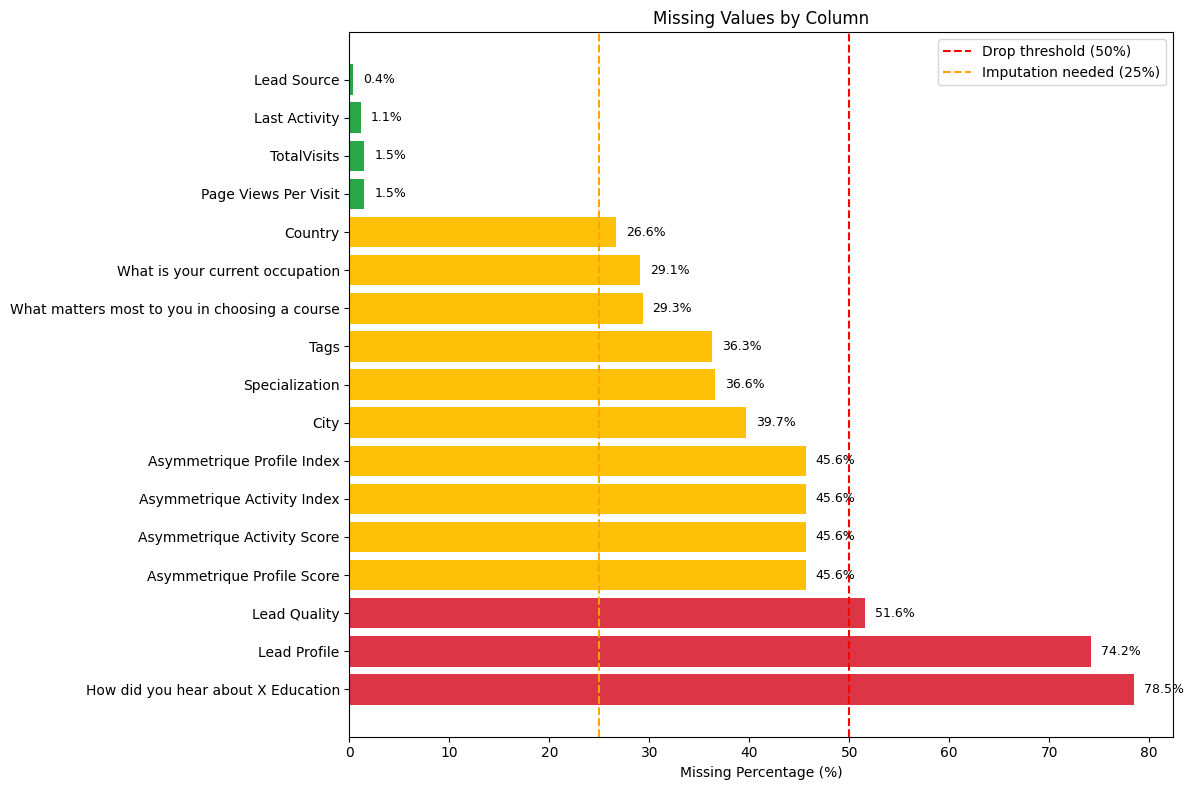

In [7]:
# Visualize missing values
fig, ax = plt.subplots(figsize=(12, 8))

missing_cols = missing_analysis[missing_analysis['Missing %'] > 0].head(20)
colors = ['#DC3545' if x > 50 else '#FFC107' if x > 25 else '#28A745' for x in missing_cols['Missing %']]

bars = ax.barh(missing_cols['Column'], missing_cols['Missing %'], color=colors)
ax.set_xlabel('Missing Percentage (%)')
ax.set_title('Missing Values by Column')
ax.axvline(x=50, color='red', linestyle='--', label='Drop threshold (50%)')
ax.axvline(x=25, color='orange', linestyle='--', label='Imputation needed (25%)')
ax.legend()

# Add percentage labels
for bar, pct in zip(bars, missing_cols['Missing %']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/figures/missing_values.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Step 3: Drop High-Missing Columns (>50%)

Columns with more than 50% missing values cannot be reliably imputed and will be dropped.

In [8]:
# Identify columns with >50% missing
high_missing_cols = missing_analysis[missing_analysis['Missing %'] > 50]['Column'].tolist()

print("Columns to drop (>50% missing):")
print("=" * 50)
for col in high_missing_cols:
    pct = missing_analysis[missing_analysis['Column'] == col]['Missing %'].values[0]
    print(f"  - {col}: {pct:.1f}% missing")

print(f"\nTotal columns to drop: {len(high_missing_cols)}")

Columns to drop (>50% missing):
  - How did you hear about X Education: 78.5% missing
  - Lead Profile: 74.2% missing
  - Lead Quality: 51.6% missing

Total columns to drop: 3


In [9]:
# Drop high-missing columns
df_cleaned = df.drop(columns=high_missing_cols)

print(f"\nShape after dropping high-missing columns:")
print(f"  Before: {df.shape[1]} columns")
print(f"  After: {df_cleaned.shape[1]} columns")
print(f"  Dropped: {len(high_missing_cols)} columns")


Shape after dropping high-missing columns:
  Before: 37 columns
  After: 34 columns
  Dropped: 3 columns


---

## Step 4: Drop Identifier Columns

Identifier columns (Prospect ID, Lead Number) are not predictive and should be removed.

In [10]:
# Identify and drop identifier columns
id_columns = ['Prospect ID', 'Lead Number']
id_cols_present = [col for col in id_columns if col in df_cleaned.columns]

print("Dropping identifier columns:")
for col in id_cols_present:
    print(f"  - {col}")

df_cleaned = df_cleaned.drop(columns=id_cols_present, errors='ignore')
print(f"\nShape after dropping identifiers: {df_cleaned.shape}")

Dropping identifier columns:
  - Prospect ID
  - Lead Number

Shape after dropping identifiers: (9240, 32)


---

## Step 5: Handle Remaining Missing Values

For columns with <50% missing, we'll apply appropriate imputation strategies:
- **Numerical columns:** Median imputation
- **Categorical columns:** Mode imputation or 'Unknown' category

In [11]:
# Re-analyze missing values after dropping columns
missing_remaining = missing_value_analysis(df_cleaned)
missing_remaining = missing_remaining[missing_remaining['Missing %'] > 0]

print("Remaining columns with missing values:")
print("=" * 60)
print(missing_remaining.to_string(index=False))

Remaining columns with missing values:
                                       Column  Missing Count  Missing % Data Type
                  Asymmetrique Activity Score           4218      45.65   float64
                  Asymmetrique Activity Index           4218      45.65    object
                   Asymmetrique Profile Score           4218      45.65   float64
                   Asymmetrique Profile Index           4218      45.65    object
                                         City           3669      39.71    object
                               Specialization           3380      36.58    object
                                         Tags           3353      36.29    object
What matters most to you in choosing a course           2709      29.32    object
              What is your current occupation           2690      29.11    object
                                      Country           2461      26.63    object
                         Page Views Per Visit            13

In [12]:
# Identify numerical and categorical columns with missing values
# Get columns by dtype directly from the dataframe
num_cols_missing = [col for col in df_cleaned.columns 
                    if df_cleaned[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                    and df_cleaned[col].isnull().any()]

cat_cols_missing = [col for col in df_cleaned.columns 
                    if df_cleaned[col].dtype == 'object' 
                    and df_cleaned[col].isnull().any()]

print(f"Numerical columns to impute (median): {num_cols_missing}")
print(f"Categorical columns to impute (mode/'Unknown'): {cat_cols_missing}")

Numerical columns to impute (median): ['TotalVisits', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']
Categorical columns to impute (mode/'Unknown'): ['Lead Source', 'Last Activity', 'Country', 'Specialization', 'What is your current occupation', 'What matters most to you in choosing a course', 'Tags', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index']


In [13]:
# Impute numerical columns with median
for col in num_cols_missing:
    median_val = df_cleaned[col].median()
    df_cleaned[col].fillna(median_val, inplace=True)
    print(f"Imputed {col} with median: {median_val:.2f}")

Imputed TotalVisits with median: 3.00
Imputed Page Views Per Visit with median: 2.00
Imputed Asymmetrique Activity Score with median: 14.00
Imputed Asymmetrique Profile Score with median: 16.00


In [14]:
# Impute categorical columns with mode or 'Unknown'
for col in cat_cols_missing:
    missing_pct = df_cleaned[col].isnull().mean() * 100
    
    if missing_pct > 25:
        # High missing - use 'Unknown' category to preserve information
        df_cleaned[col].fillna('Unknown', inplace=True)
        print(f"Imputed {col} with 'Unknown' ({missing_pct:.1f}% missing)")
    else:
        # Low missing - use mode
        mode_val = df_cleaned[col].mode()[0]
        df_cleaned[col].fillna(mode_val, inplace=True)
        print(f"Imputed {col} with mode: '{mode_val}' ({missing_pct:.1f}% missing)")

Imputed Lead Source with mode: 'Google' (0.4% missing)
Imputed Last Activity with mode: 'Email Opened' (1.1% missing)
Imputed Country with 'Unknown' (26.6% missing)
Imputed Specialization with 'Unknown' (36.6% missing)
Imputed What is your current occupation with 'Unknown' (29.1% missing)
Imputed What matters most to you in choosing a course with 'Unknown' (29.3% missing)
Imputed Tags with 'Unknown' (36.3% missing)
Imputed City with 'Unknown' (39.7% missing)
Imputed Asymmetrique Activity Index with 'Unknown' (45.6% missing)
Imputed Asymmetrique Profile Index with 'Unknown' (45.6% missing)


In [15]:
# Final catch-all: Handle any remaining missing values
# This ensures no edge cases are missed
for col in df_cleaned.columns:
    if df_cleaned[col].isnull().any():
        if df_cleaned[col].dtype in ['float64', 'int64', 'float32', 'int32']:
            fill_val = df_cleaned[col].median()
            df_cleaned[col].fillna(fill_val, inplace=True)
            print(f"[Final cleanup] Imputed {col} with median: {fill_val}")
        else:
            fill_val = df_cleaned[col].mode()[0] if not df_cleaned[col].mode().empty else 'Unknown'
            df_cleaned[col].fillna(fill_val, inplace=True)
            print(f"[Final cleanup] Imputed {col} with: '{fill_val}'")

# Verify no missing values remain
remaining_missing = df_cleaned.isnull().sum().sum()
print(f"\nTotal missing values remaining: {remaining_missing}")
assert remaining_missing == 0, "Missing values still present!"


Total missing values remaining: 0


---

## Step 6: Check for Duplicates

In [16]:
# Check for duplicate rows
duplicates = df_cleaned.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")

if duplicates > 0:
    print("Removing duplicates...")
    df_cleaned = df_cleaned.drop_duplicates()
    print(f"Shape after removing duplicates: {df_cleaned.shape}")
else:
    print("No duplicates to remove.")

Duplicate rows found: 1366
Removing duplicates...
Shape after removing duplicates: (7874, 32)


---

## Step 7: Data Type Corrections

In [17]:
# Ensure binary columns are encoded correctly
binary_cols = ['Do Not Email', 'Do Not Call', 'A free copy of Mastering The Interview',
               'Search', 'Magazine', 'Newspaper Article', 'X Education Forums',
               'Newspaper', 'Digital Advertisement', 'Through Recommendations',
               'Receive More Updates About Our Courses', 'Update me on Supply Chain Content',
               'Get updates on DM Content', 'I agree to pay the amount through cheque']

for col in binary_cols:
    if col in df_cleaned.columns:
        # Map Yes/No to 1/0
        if df_cleaned[col].dtype == 'object':
            df_cleaned[col] = df_cleaned[col].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)
            print(f"Converted {col} to binary (0/1)")

Converted Do Not Email to binary (0/1)
Converted Do Not Call to binary (0/1)
Converted A free copy of Mastering The Interview to binary (0/1)
Converted Search to binary (0/1)
Converted Magazine to binary (0/1)
Converted Newspaper Article to binary (0/1)
Converted X Education Forums to binary (0/1)
Converted Newspaper to binary (0/1)
Converted Digital Advertisement to binary (0/1)
Converted Through Recommendations to binary (0/1)
Converted Receive More Updates About Our Courses to binary (0/1)
Converted Update me on Supply Chain Content to binary (0/1)
Converted Get updates on DM Content to binary (0/1)
Converted I agree to pay the amount through cheque to binary (0/1)


---

## Final Dataset Summary

In [18]:
print("="*60)
print("CLEANED DATASET SUMMARY")
print("="*60)
print(f"\nShape: {df_cleaned.shape[0]} rows x {df_cleaned.shape[1]} columns")
print(f"\nTarget Variable Distribution:")
print(df_cleaned['Converted'].value_counts())
print(f"\nConversion Rate: {df_cleaned['Converted'].mean():.1%}")
print(f"\nMissing Values: {df_cleaned.isnull().sum().sum()}")
print(f"Duplicate Rows: {df_cleaned.duplicated().sum()}")

CLEANED DATASET SUMMARY

Shape: 7874 rows x 32 columns

Target Variable Distribution:
0    4738
1    3136
Name: Converted, dtype: int64

Conversion Rate: 39.8%

Missing Values: 0
Duplicate Rows: 0


In [19]:
# Column types summary
print("\nColumn Types:")
print(df_cleaned.dtypes.value_counts())


Column Types:
int64      16
object     12
float64     4
dtype: int64


In [20]:
# Final column list
print("\nFinal Columns:")
for i, col in enumerate(df_cleaned.columns, 1):
    print(f"{i:2}. {col} ({df_cleaned[col].dtype})")


Final Columns:
 1. Lead Origin (object)
 2. Lead Source (object)
 3. Do Not Email (int64)
 4. Do Not Call (int64)
 5. Converted (int64)
 6. TotalVisits (float64)
 7. Total Time Spent on Website (int64)
 8. Page Views Per Visit (float64)
 9. Last Activity (object)
10. Country (object)
11. Specialization (object)
12. What is your current occupation (object)
13. What matters most to you in choosing a course (object)
14. Search (int64)
15. Magazine (int64)
16. Newspaper Article (int64)
17. X Education Forums (int64)
18. Newspaper (int64)
19. Digital Advertisement (int64)
20. Through Recommendations (int64)
21. Receive More Updates About Our Courses (int64)
22. Tags (object)
23. Update me on Supply Chain Content (int64)
24. Get updates on DM Content (int64)
25. City (object)
26. Asymmetrique Activity Index (object)
27. Asymmetrique Profile Index (object)
28. Asymmetrique Activity Score (float64)
29. Asymmetrique Profile Score (float64)
30. I agree to pay the amount through cheque (int64)
3

---

## Save Cleaned Dataset

In [21]:
# Create output directory
output_path = 'outputs/datasets/cleaned'
os.makedirs(output_path, exist_ok=True)

# Save cleaned dataset
df_cleaned.to_csv(f'{output_path}/leads_cleaned.csv', index=False)
print(f"Cleaned dataset saved to: {output_path}/leads_cleaned.csv")

Cleaned dataset saved to: outputs/datasets/cleaned/leads_cleaned.csv


---

## Cleaning Summary & Rationale

### Actions Taken

| Action | Columns Affected | Rationale |
|--------|------------------|----------|
| Replace 'Select' with NaN | Multiple categorical | 'Select' is a placeholder, not real data |
| Drop >50% missing | Lead Profile, How did you hear, Lead Quality | Too much missing data to reliably impute |
| Drop identifiers | Prospect ID, Lead Number | Not predictive features |
| Median imputation | TotalVisits, Page Views Per Visit | Robust to outliers for skewed distributions |
| Mode/'Unknown' imputation | Specialization, Tags, etc. | Preserves categorical distribution |
| Binary encoding | Do Not Email, Do Not Call, etc. | Convert Yes/No to 1/0 for ML |

### Next Steps
- Proceed to Notebook 03 for feature engineering
- Create derived features
- Encode remaining categorical variables
- Scale numerical features